In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

In [11]:
### ONLY FOR THE ANALYSES OF THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

Generate pairs

In [12]:
N = 1000 #nb of pairs

In [13]:
print_shapes_Net = False
print_errors = False

In [14]:
class Siamese_net(nn.Module):
    def __init__(self):
        super(Siamese_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 10)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, data):
        if print_shapes_Net:
            print("initial", data.shape) #100 2 14 14
            
        final_layer = []
        for i in range(2):
            x = data[:,i,:,:]
            len0 = x.shape[0]
            x = torch.reshape(x, (len0, 1, 14, 14))
            
            if print_shapes_Net:
                print("X START",x.shape) 
            
            x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
            if print_shapes_Net:
                print("conv1",x.shape) 
                
            x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
            if print_shapes_Net:
                print("conv2",x.shape)
            
            x = F.relu(self.fc1(x.view(-1, 256)))
            if print_shapes_Net:
                print("fc1",x.shape) 
                
            final_layer.append(x)
            
        #final_layer = torch.abs(final_layer[1] - final_layer[0])
        final_layer = torch.cat((final_layer[1], final_layer[0]), 1)
                
        final_layer = self.fc2(final_layer)
        if print_shapes_Net:
            print("final",final_layer.shape) 
            
        return final_layer

In [15]:
def train_model(model, train_input, train_target, mini_batch_size, lr, nb_epoch):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    
    for e in range(nb_epoch):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss = sum_loss + loss.item()
        #print(e, sum_loss)

In [16]:
def compute_nb_errors_targets(model, input, target):
    nb_errors = 0
    output = model(input)
    _, predicted_target = output.max(1) #max probabilities of target
    
    for b in range(1000):
        if target[b,int(predicted_target[b])] <= 0:
            nb_errors = nb_errors + 1
            
    return nb_errors

In [17]:
def reshape_targets(train_target, test_target):
    new_train_target = torch.empty(1000,2)
    new_test_target = torch.empty(1000,2)
    for i in range(1000):
        if train_target[i] == 1 :
            new_train_target[i,0] = 0
            new_train_target[i,1] = 1

        else:
            new_train_target[i,0] = 1
            new_train_target[i,1] = 0

        if test_target[i] == 1:
            new_test_target[i,0] = 0
            new_test_target[i,1] = 1

        else:
            new_test_target[i,0] = 1
            new_test_target[i,1] = 0
            
    return new_train_target, new_test_target

In [18]:
###ANALYSE THE RESULTS
def analyse_results(train_errors, test_errors, title):
    input_size = 1000
    print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(train_errors)) / train_input.size(0),
                                                          np.mean(train_errors), input_size))
    print("Train error standard deviation : {:0.2f}".format(np.std(train_errors)))

    print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(test_errors)) / test_input.size(0),
                                                          np.mean(test_errors), input_size))
    print("Test error standard deviation : {:0.2f}".format(np.std(test_errors)))


    train_err = [x*100 / input_size for x in train_errors]
    test_err = [x*100 / input_size for x in test_errors]

    plt.figure
    plt.title(title)
    plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
    plt.ylabel("Error percentage")
    plt.show()

#### Final test

iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
iteration 10/10
Average train error 6.97% 69.70/1000
Train error standard deviation : 16.37
Average test error 14.47% 144.70/1000
Test error standard deviation : 5.08


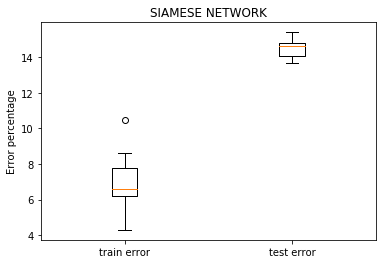

In [23]:
mini_batch_size = 100
nb_epoch = 25
lr = 0.001
nb = 10
train_errors = []
test_errors = []

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    model = Siamese_net()
    train_model(model, train_input, new_train_target, mini_batch_size, lr, nb_epoch)
    print("iteration {:d}/{:d}".format(i+1,nb))

    nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
    
    if print_errors:
        print('train error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                          nb_train_errors, train_input.size(0)))
        print('test error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                        nb_test_errors, test_input.size(0)))
        
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)

analyse_results(train_errors, test_errors, "SIAMESE NETWORK")

#### Tests

In [10]:
model = Siamese_net()
lr = 0.001
mini_batch_size = 100
nb_epoch = 25

train_model(model, train_input, new_train_target, mini_batch_size, lr, nb_epoch)
print("LR =", lr)

nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
print('train error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                  nb_train_errors, train_input.size(0)))
nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
print('test error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                    nb_test_errors, test_input.size(0)))

LR = 0.001
train error Siamese_net 6.90% 69/1000
test error Siamese_net 13.40% 134/1000


#### Choice of parameter for Siamese_net

In [101]:
# lr = 0.001 --> no overfitting
for lr in [0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Siamese_net()
    mini_batch_size = 100
    nb_epoch = 25

    train_model(model, train_input, new_train_target, mini_batch_size, lr, nb_epoch)
    print("LR =", lr)
    
    nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
    print('train error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
    nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
    print('test error Siamese_net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                    nb_test_errors, test_input.size(0)))

LR = 0.0005
train error Net 14.50% 145/1000
test error Net 18.50% 185/1000
LR = 0.001
train error Net 7.00% 70/1000
test error Net 15.30% 153/1000
LR = 0.005
train error Net 0.00% 0/1000
test error Net 14.10% 141/1000
LR = 0.01
train error Net 0.00% 0/1000
test error Net 14.20% 142/1000
LR = 0.05
train error Net 46.40% 464/1000
test error Net 47.30% 473/1000
LR = 0.1
train error Net 46.40% 464/1000
test error Net 47.30% 473/1000
LR = 0.5
train error Net 46.40% 464/1000
test error Net 47.30% 473/1000
